In [1]:
import torch 
from torch import nn 
import torchvision 
from torchvision import datasets , transforms 
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt 

In [7]:
train_data = datasets.FashionMNIST(
    root='data' , 
    train=True, 
    download=True, 
    transform=ToTensor(), 
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root='data' , 
    train=False , 
    download=True , 
    transform=ToTensor(), 
    target_transform=None 
)

100.0%
100.0%


In [8]:
firstLabel = train_data[0][1]
firstLabel

9

In [9]:
shape = train_data[0][0].shape
shape # color channel , height , width

torch.Size([1, 28, 28])

In [10]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [11]:
class_to_idx = train_data.class_to_idx 
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

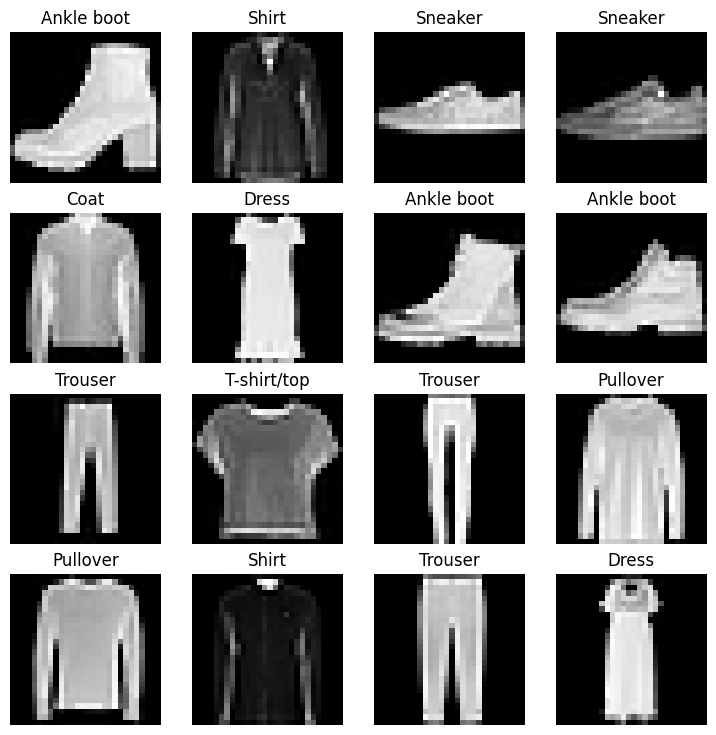

In [12]:
fig = plt.figure(figsize=(9 ,9))
rows , cols = 4, 4 
for i in range(1 , rows * cols + 1) : 
    pick = torch.randint(0 , len(train_data) , (1,)).item()
    img , label = train_data[pick]
    fig.add_subplot(rows , cols , i)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(class_names[label])
    plt.axis('off')

In [13]:
from torch.utils.data import DataLoader
train_data_loader = DataLoader(dataset=train_data , batch_size=32 , shuffle=True)
test_data_loader = DataLoader(test_data , 32 , shuffle=True)

In [14]:
batch , label = next(iter(train_data_loader))
batch.shape , len(batch) , label , len(label)

(torch.Size([32, 1, 28, 28]),
 32,
 tensor([8, 1, 3, 6, 4, 2, 2, 4, 6, 2, 3, 9, 7, 2, 6, 2, 9, 5, 3, 3, 7, 4, 0, 8,
         8, 9, 2, 4, 0, 1, 7, 4]),
 32)

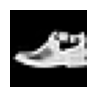

In [15]:
pick = torch.randint(0 , len(batch) , (1,)).item()
plt.figure(figsize=(1, 1))
plt.imshow(batch[pick].squeeze() , cmap='gray')
plt.axis('off');

In [16]:
flattenModel = nn.Flatten()
flimage = flattenModel(batch[pick])
flimage.shape

torch.Size([1, 784])

In [ ]:
class MyCnnModel(nn.Module): 
    def __init__(self , input_shape :int  , kernel_size: int , stride :int , padding:int, output_shape:int , hidden_unit:int): 
        super().__init__()

        self.layer_stack = nn.Sequential(
            nn.Conv2d(input_shape , 32, kernel_size=kernel_size, stride=stride , padding=padding),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(32 , 64, kernel_size=kernel_size, stride=stride , padding=padding),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(64 , 32, kernel_size=kernel_size, stride=stride , padding=padding),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_unit , output_shape)
        )

    def forward (self ,x:torch.tensor)->torch.tensor: 
        x=  self.layer_stack(x)
        return self.classifier(x)


In [ ]:
class FashionMNISTModelV2(nn.Module):

    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, 
                      stride=1,
                      padding=1), 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) 
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7, 
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1, 
    hidden_units=10, 
    output_shape=len(class_names))
model_2

In [ ]:
flimage.shape[1]

784

In [ ]:
model = MyCnnModel(
    input_shape=flimage.shape[1], 
    hidden_units=16,
    output_shape=len(class_names)
)

In [ ]:
model(torch.rand([1 , 1 , 28 , 28]))

tensor([[-0.6452, -0.1905,  0.1645,  0.5239,  0.3396, -0.2867,  0.2319,  0.0653,
         -0.0502,  0.2203]], grad_fn=<AddmmBackward0>)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimzer = torch.optim.SGD(params=model.parameters() , lr=1e-1)

In [ ]:
def measure_metrics(ypred, ytrue):
    from torchmetrics import Accuracy
    accuracy = Accuracy(task='multiclass', num_classes=10)
    return {
        "accuracy": accuracy(ypred, ytrue)
    }


In [ ]:
def print_train_time(start:float , end:float, device:torch.device = None): 
    total_time = end - start 
    return total_time

In [ ]:
from timeit import default_timer as timer 
start = timer()
end = timer() 
print_train_time(start, end)

1.3299999409355223e-05

In [ ]:
from tqdm.auto import tqdm 

c:\Users\Alchemist\Desktop\pytorch\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from typing import Callable

def eval_model(model:torch.nn.Module , dataLoader : torch.utils.data.DataLoader ,
                loss_fn : torch.nn.Module , 
                acc_fn:Callable[[torch.tensor , torch.tensor] , dict]): 
    test_loss = 0 
    test_acc = 0
    model.eval()
    with torch.inference_mode(): 
        for x,  y in dataLoader: 
            test_pred = model(x)
            loss = loss_fn(test_pred, y)
            test_loss += loss.item()
            acc = acc_fn(torch.argmax(test_pred , dim=1) , y)
            test_acc += acc['accuracy'].item()

    test_loss /= len(dataLoader)
    test_acc /= len(dataLoader)
    return test_loss , test_acc


In [ ]:
epochs = 3
train_time = timer()

for epoch in tqdm(range(epochs)): 
    print(f'epoch:{epoch}')
    train_loss = 0 

    # for index, (data , target)  in enumerate(train_data_loader): 
    #print(index) # 1875 index

    for batch , (x ,y) in enumerate(train_data_loader): 
        model.train()
        ypred = model(x)
        loss = loss_fn(ypred , y)
        train_loss += loss.item()
        optimzer.zero_grad() 
        loss.backward()
        optimzer.step()

    train_loss /= len(train_data_loader) #1875

    test_loss , test_acc = eval_model(model , test_data_loader, loss_fn , measure_metrics)
end_train_time = timer() 

print(f'the time to run was {print_train_time(train_time , end_train_time):.2f}')
print(f'train loss is {train_loss}')
print(f'test loss is {test_loss}')
print(f'test accurasy is {test_acc}')


  0%|          | 0/3 [00:00<?, ?it/s]

epoch:0


 33%|███▎      | 1/3 [00:03<00:07,  3.98s/it]

epoch:1


 67%|██████▋   | 2/3 [00:07<00:03,  3.81s/it]

epoch:2


100%|██████████| 3/3 [00:11<00:00,  3.82s/it]

the time to run was 11.45
train loss is 0.40507063740491867
test loss is 0.4734552786373102
test accurasy is 0.8346645367412141
